<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [16]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')


import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle

In [17]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [18]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])

dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 33
decay_steps     = 2300
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]
                
          

def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)



def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

In [20]:
try:
    train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))
    print('data loaded from file')
except:
    train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_))
    valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_))
    test_data = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_))


    keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass','SN','MJD','plate','fiber', 'mean', 'std')

    train = {}
    for item, key in zip(train_data.files, keys):
        train[key] = train_data[item]


    valid = {}
    for item, key in zip(valid_data.files, keys):
        valid[key] =  valid_data[item]

    test = {}
    for item, key in zip(test_data.files, keys):
        test[key] = test_data[item]


    le = preprocessing.LabelEncoder()
    le.fit(train['subclass'])
    train['subclass'] = le.transform(train['subclass'])
    valid['subclass'] = le.transform(valid['subclass'])
    test['subclass']  = le.transform(test['subclass'])
    print(le.classes_, le.transform(le.classes_))        

    pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'wb'))


[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


In [15]:
test['fiber']

array([ 94, 537, 161, ...,  85, 343, 555])

In [15]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 3
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    x = dense_block(x,out_features[ii])
    
x = dense_block(x,latent_dim,non_lin=False)
x = Reshape((latent_dim,1))(x)

for ii in range(n_layers-1):
    if conditional:
        x = dense_cond_block(x,z,out_features[-1-ii])
    else:
        x = dense_block(x,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
if conditional:
    x = dense_cond_block(x,z,dim, non_lin=False)
else:
    x = dense_block(x,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()



Model: "custom_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 1000)         0           input_6[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1000)         1001000     flatten_6[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 1000)         0           dense_6[0][0]                    
_____________________________________________________________________________________

In [16]:
path = os.path.join(root_models,'full_ae_model_%s_run%s'%(label_2,RUN))

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final validation reconstruction error:', np.sqrt(recon_error))


lstm_ae.save(path)

Epoch 1/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 4.6755
Epoch 2/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 2.0918
Epoch 3/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 2.0082
Epoch 4/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 1.7219
Epoch 5/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 1.6686
Epoch 6/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 1.6060
Epoch 7/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 1.5415
Epoch 8/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 1.4997
Epoch 9/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 1.4873
Epoch 10/40
2131/2131 [==============================] - 4s 2ms/step - training_loss: 1.4618
Epoch 11/40
2131/2131 [==============================] - 4s 2ms/step - training

In [17]:
for label in np.arange(7):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.2902430606249267
training:  1.2778457710208464
[b'AGN']
validation:  1.3770109444472507
training:  1.5974697691146298
[b'AGN BROADLINE']
validation:  2.197294381578875
training:  1.7358257493670923
[b'BROADLINE']
validation:  1.8590851520624816
training:  1.6675439609890865
[b'STARBURST']
validation:  1.6045615590882398
training:  1.5470686431434675
[b'STARBURST BROADLINE']
validation:  1.7158831283043707
training:  1.7231777744373442
[b'STARFORMING']
validation:  1.408536090232743
training:  1.3940754524858998


In [18]:
def bootstrap(train_data, batch_size):
    index   = np.arange(len(train['spec']))
    metrics = []
    for ii in range(1000):
        sample    = np.random.choice(index, size=batch_size, replace=False, p=None)
        res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
        metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
        metrics.append(metric)
    return np.mean(metrics), np.std(metrics)

In [19]:
bootstrap(train, batch_size=len(valid_data))

(1.344689045895405, 0.10352089683509873)

In [20]:
### concatenate and split input
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [21]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [33]:
encoder = extract_layers(lstm_ae,0,13)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aab8ee93ac0>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac9b27af70>
2 <tensorflow.python.keras.layers.core.Dense object at 0x2aac9b27a730>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac9b27a0a0>
4 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac9b2f33a0>
5 <tensorflow.python.keras.layers.core.Dropout object at 0x2aac9b2f3790>
6 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac9b2b0460>
7 <tensorflow.python.keras.layers.core.Dense object at 0x2aac9b2a0100>
8 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac9b2a90a0>
9 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac9b26d3a0>
10 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac9a880670>
11 <tensorflow.python.keras.layers.core.Dense object at 0x2aac9b26d5b0>
12 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac9b25f070>
Model: "

In [36]:
if conditional:
    decoder = extract_layers_base(lstm_ae,13,25)
    input      = Input(shape=(latent_dim,1))
    input_type = Input(shape=(1,1))
    print(decoder[0])
    x          = decoder[0]((input,input_type))
    for ii in range(1,len(decoder)):
        try:
            x = decoder[ii](x)
        except:
            x = decoder[ii]((x, input_type))
    decoder = Model((input,input_type),x)
else:
    decoder = extract_layers(lstm_ae,13,25)
    decoder.build((None,latent_dim,1))

13 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac9b26daf0>
14 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac9b25f5e0>
15 <tensorflow.python.keras.layers.core.Dense object at 0x2aac9b265f70>
16 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac9b2874f0>
17 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac9b287250>
18 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac9b25b9a0>
19 <tensorflow.python.keras.layers.core.Dense object at 0x2aac9b25b670>
20 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac9b2c0c10>
21 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac9b2c01f0>
22 <tensorflow.python.keras.layers.core.Dropout object at 0x2aac9b2c0280>
23 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac9b2989d0>
24 <tensorflow.python.keras.layers.core.Dense object at 0x2aac9b2ded90>


In [37]:
decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 10, 1)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 590)               6490      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 590)               0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 590, 1)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 590)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1000)            

In [38]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [41]:
if conditional:
    decoded_train  = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['subclass'],-1)))
    decoded_test   = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['subclass'],-1)))
    decoded_valid  = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['subclass'],-1)))
else:
    decoded_train  = decoder.predict(encoded_train)
    decoded_test   = decoder.predict(encoded_test)
    decoded_valid  = decoder.predict(encoded_valid)   

In [78]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1


In [79]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [80]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)

In [81]:
np.save(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)

In [82]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test, train['mean'], train['std']])

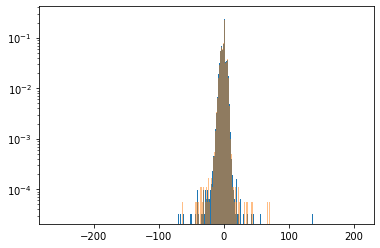

In [54]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

In [55]:
encoded_valid.shape

(6596, 10)

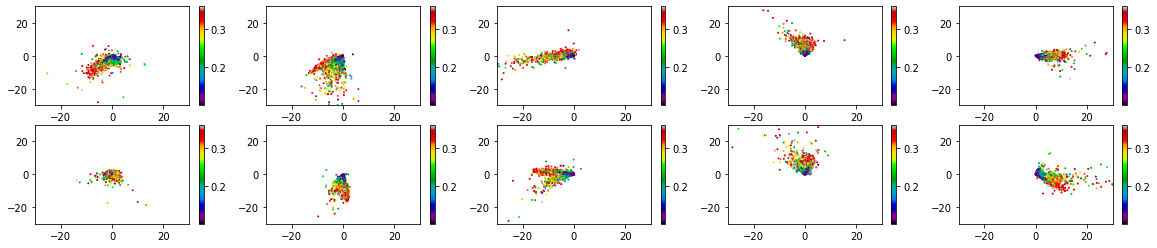

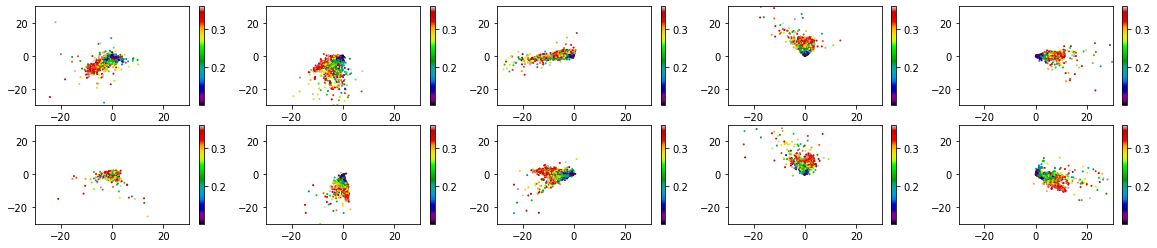

In [56]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['z'][:len(encoded_valid)], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

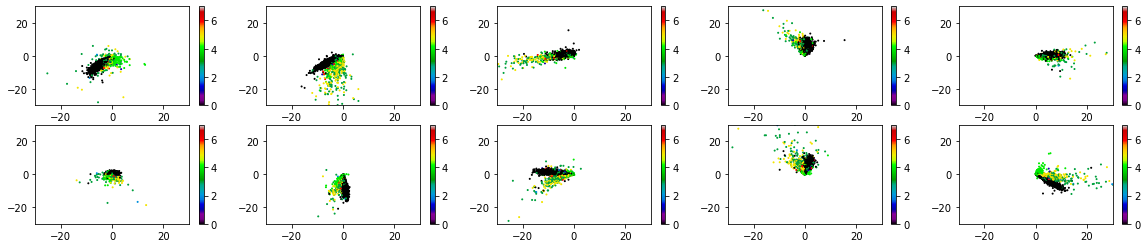

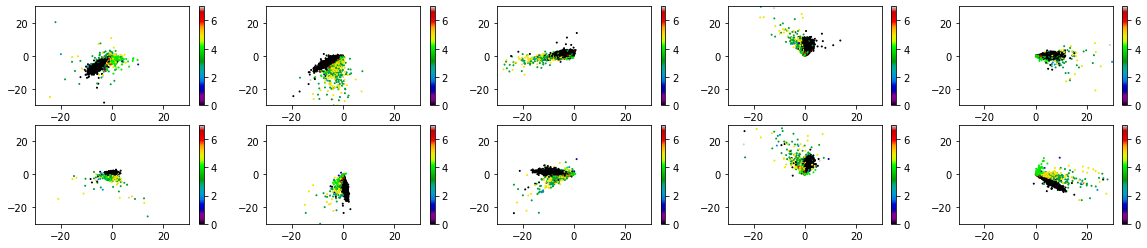

In [59]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='nipy_spectral', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['subclass'][:len(encoded_valid)], cmap='nipy_spectral', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [60]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

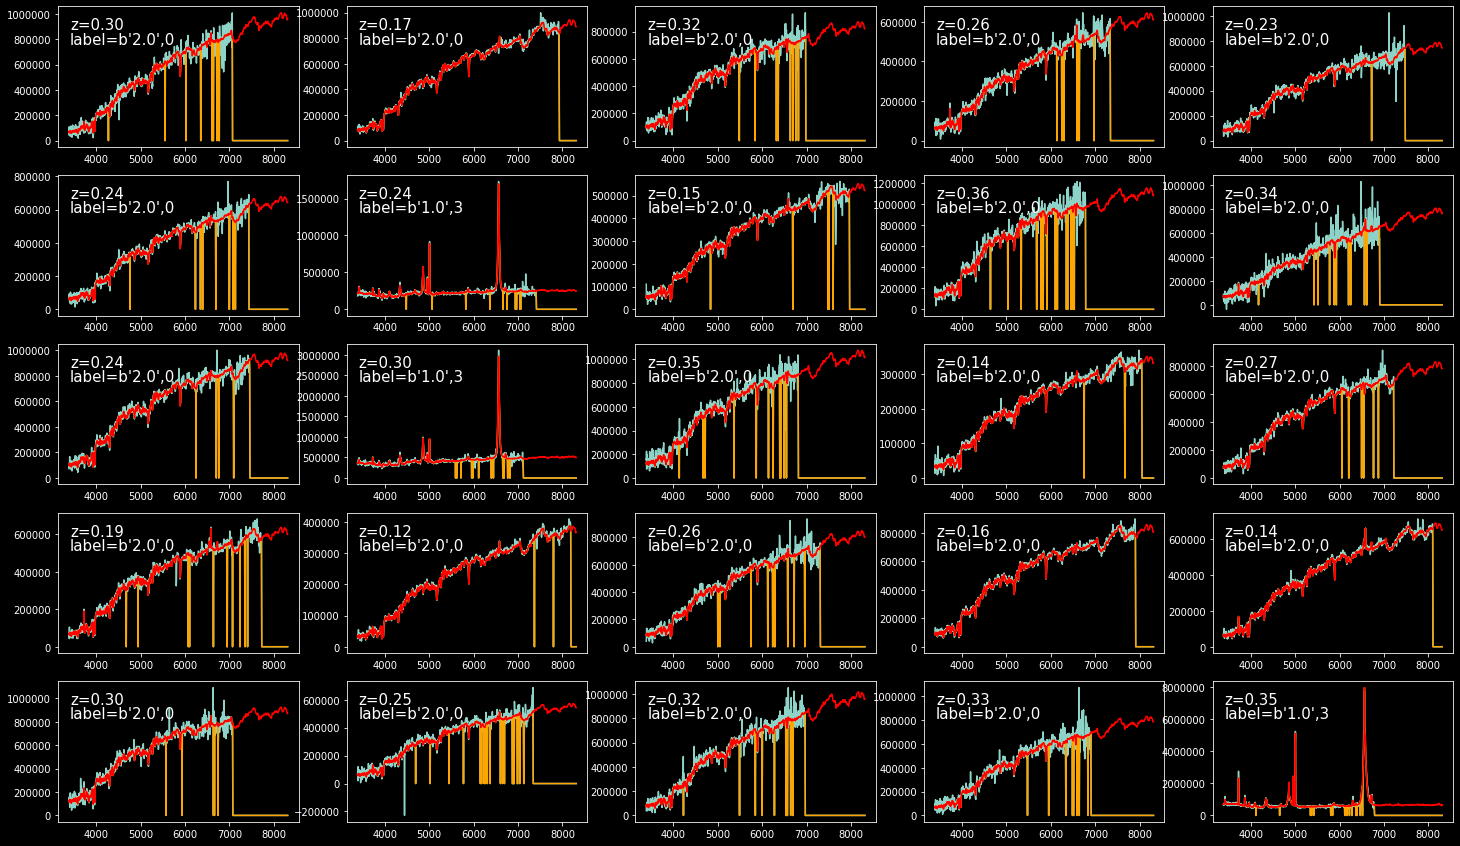

In [61]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec']*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean']), color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid['z'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid['class'][ii],valid['subclass'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

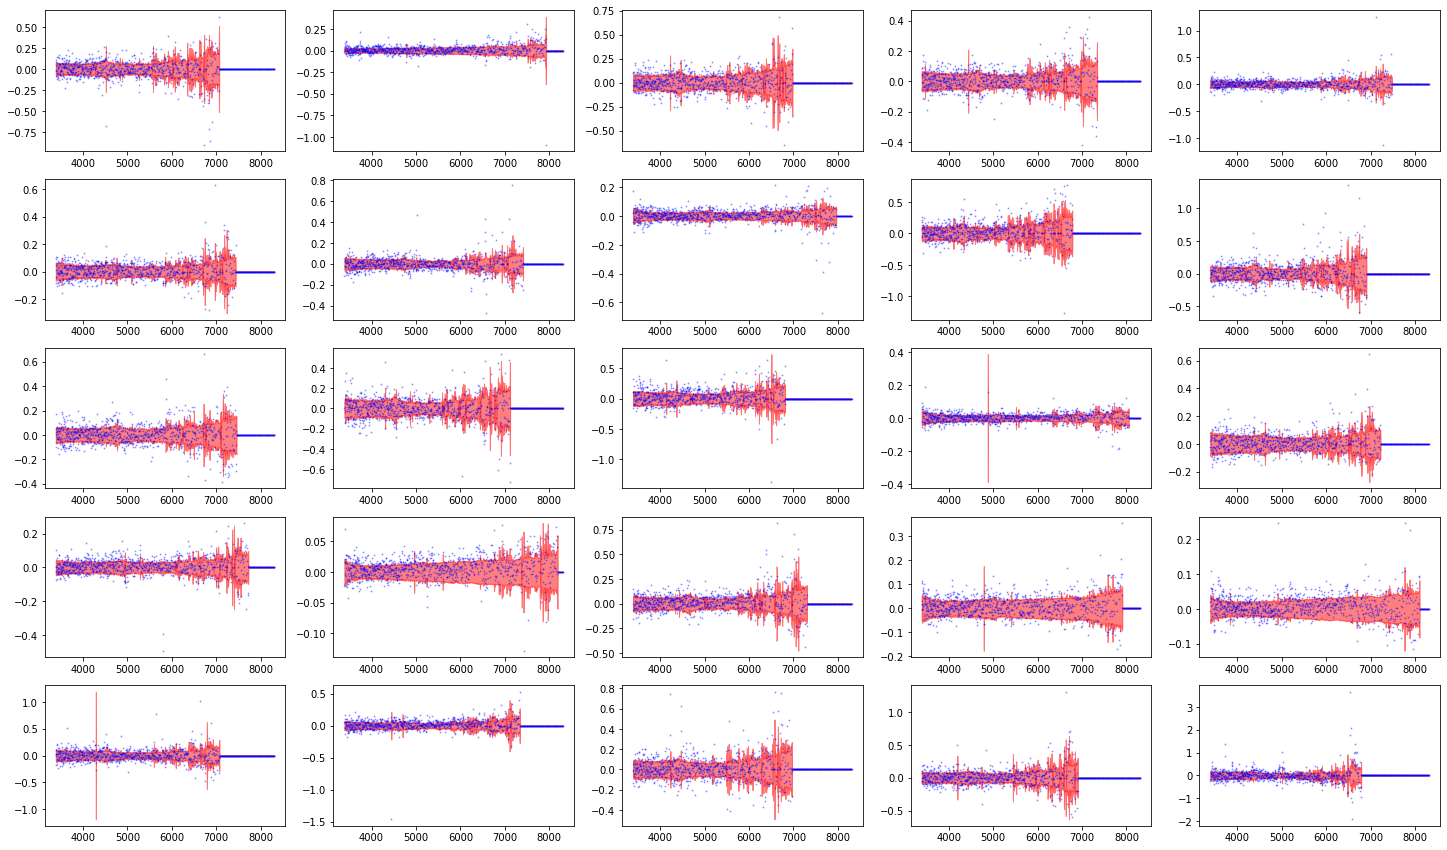

In [62]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [63]:
### Look at reconstruction ability as function of wavelength

In [64]:
def loss_by_wl(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [65]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

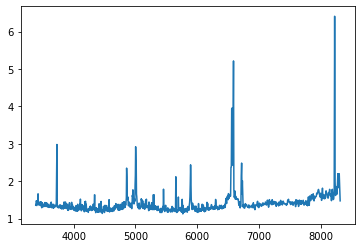

In [66]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0))

In [67]:
np.mean(loss[0]/np.mean(valid['mask'],axis=0))

1.3914626928137277

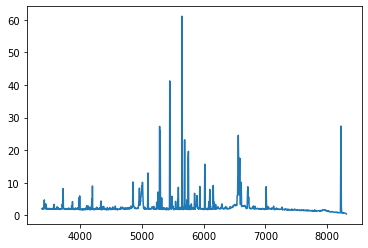

In [68]:
plt.plot(new_wl[:-1],loss[1])

In [69]:
np.tile(np.expand_dims(encoded_valid[0],(0,-1)),(8,1,1)).shape, np.expand_dims(np.arange(8),-1).shape

((8, 10, 1), (8, 1))

In [70]:
encoded_train.shape

(70311, 10)